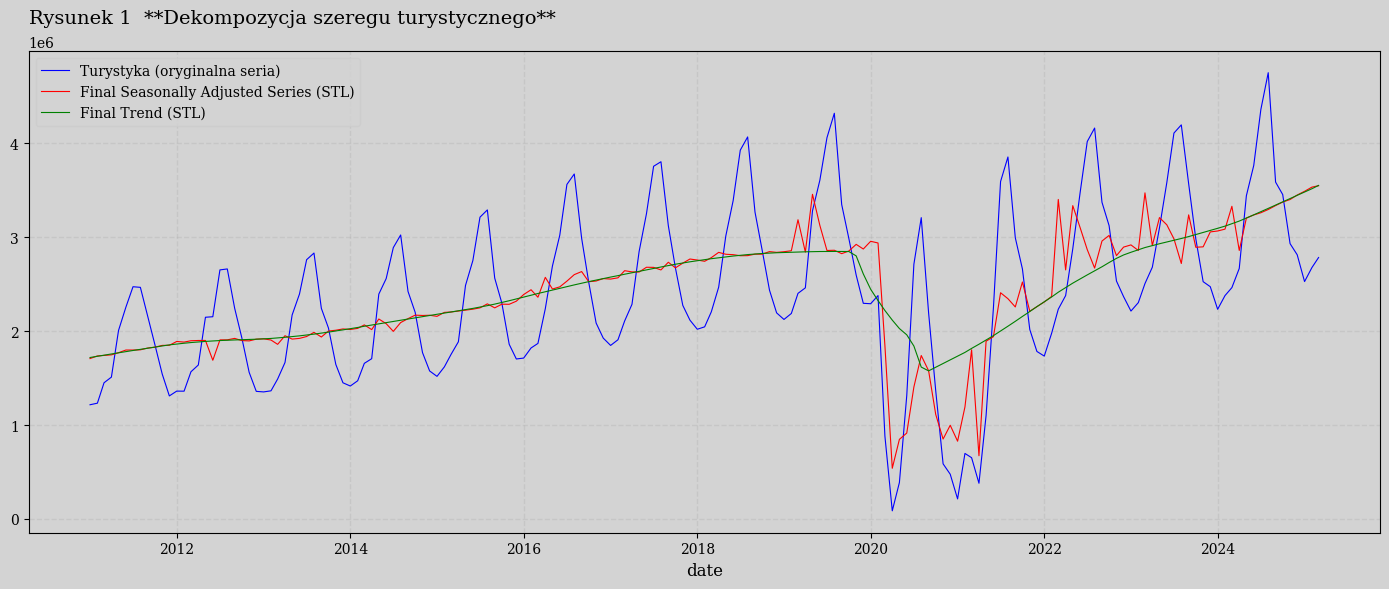

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# --- Styl wykresów (taki sam jak poprzednio) ------------------------------
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman', 'DejaVu Serif', 'Arial'],
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'lines.linewidth': 0.8,
    'grid.linestyle': '--',
    'grid.color': '#aaaaaa',
    'grid.alpha': 0.3,
    'figure.figsize': (14, 8),
    'figure.facecolor': 'lightgrey',
    'axes.facecolor': 'lightgrey'
})

# --- Wczytanie danych turystycznych ---------------------------------------
file_path = "turystyka_czasowe_2.xlsx"
df = pd.read_excel(file_path)

if "Data" in df.columns:                      # zakładamy kolumnę „Data”
    df["Data"] = pd.to_datetime(df["Data"])
    y = df.set_index("Data")["Wartosc"].dropna()
    y = y.asfreq("MS")                       # miesięczna częstotliwość
else:                                        # gdy brak kolumny „Data”
    y = df["Wartosc"].dropna()               # użyj domyślnego indeksu

# --- STL: trend + sezonowość + reszty --------------------------------------
stl   = STL(y, period=12, robust=True).fit()
trend = stl.trend
seasonal = stl.seasonal
y_sa = y - seasonal                          # seria oczyszczona z sezonowości
resid = stl.resid

# --- Wykres Ala-Demetra ----------------------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(y,        color="blue",  label="Turystyka (oryginalna seria)")
plt.plot(y_sa,     color="red",   label="Final Seasonally Adjusted Series (STL)")
plt.plot(trend,    color="green", label="Final Trend (STL)")

plt.title("Rysunek 1  **Dekompozycja szeregu turystycznego**", loc="left", pad=20)
plt.xlabel("date")
plt.grid(True, which="major", linewidth=1.0)
plt.grid(True, which="minor", linestyle=":", linewidth=0.5)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

# (opcjonalnie) zapis do pliku:
# plt.savefig("dekompozycja_turystyka.png", dpi=300)


In [9]:
import pandas as pd
import statsmodels.api as sm           # tylko jeśli chcesz DF „ręczny”
from statsmodels.tsa.stattools import adfuller

# ── Wczytanie danych ───────────────────────────────────────────────────────
file_path = "turystyka_czasowe_2.xlsx"
df = pd.read_excel(file_path)

if "Data" in df.columns:               # zakładamy kolumnę „Data”
    df["Data"] = pd.to_datetime(df["Data"])
    y = df.set_index("Data")["Wartosc"].dropna()
    y = y.asfreq("MS")                 # miesięczna częstotliwość
else:                                  # gdy brak kolumny „Data”
    y = df["Wartosc"].dropna()

# ── Automatyczny test ADF (stała, maxlag = 8, autolag = AIC) ───────────────
print("\n--- Automatyczny test ADF (poziomy, autolag=AIC, maxlag=8) ---")
adf_stat, p_val, used_lag, nobs, crit_vals, icbest = adfuller(
    y,
    maxlag=8,            # rozważ lag 0–8
    regression="c",      # z stałą
    autolag="AIC"        # wybór lags wg AIC
)

print(f"Statystyka ADF       : {adf_stat:.4f}")
print(f"Wartość p            : {p_val:.4f}")
print(f"Wybrany lag (AIC)    : {used_lag}")
print(f"Najlepsze AIC        : {icbest:.4f}")
print("Wartości krytyczne   :")
for level, val in crit_vals.items():
    print(f"  {level}%: {val:.4f}")

if p_val < 0.05:
    print("⇒ Odrzucamy H₀ – szereg w poziomach jest stacjonarny.")
else:
    print("⇒ Brak podstaw do odrzucenia H₀ – szereg w poziomach prawdopodobnie niestacjonarny.")



--- Automatyczny test ADF (poziomy, autolag=AIC, maxlag=8) ---
Statystyka ADF       : -1.2901
Wartość p            : 0.6337
Wybrany lag (AIC)    : 8
Najlepsze AIC        : 4556.0239
Wartości krytyczne   :
  1%%: -3.4714
  5%%: -2.8796
  10%%: -2.5764
⇒ Brak podstaw do odrzucenia H₀ – szereg w poziomach prawdopodobnie niestacjonarny.


In [ ]:
    import pandas as pd
    import numpy as np
    import statsmodels.api as sm
    from statsmodels.stats.diagnostic import acorr_breusch_godfrey
    from statsmodels.tsa.stattools import adfuller

    # --- Wczytanie danych ------------------------------------------------------
    file_path = "turystyka_czasowe_2.xlsx"
    df = pd.read_excel(file_path)

    if "Data" in df.columns:
        df["Data"] = pd.to_datetime(df["Data"])
        y = df.set_index("Data")["Wartosc"].dropna()
    else:
        y = df["Wartosc"].dropna().reset_index(drop=True)

    # ===========================================================================
    # 1. TESTY NA ORYGINALNYM SZEREGU (bez różnicowania)
    # ===========================================================================
    print("\n#################  TESTY NA SZEREGU W POZIOMACH  #################")

    # --- Klasyczny Dickey–Fuller (OLS) ----------------------------------------
    yt    = y[1:].reset_index(drop=True)
    yt_1  = y.shift(1)[1:].reset_index(drop=True)
    delta = yt - yt_1

    print("\n--- Dickey–Fuller ze stałą (poziomy) ---")
    X_const = sm.add_constant(yt_1)
    model_const_lvl = sm.OLS(delta, X_const).fit()
    print(model_const_lvl.summary())
    print(f"Statystyka t (DF, ze stałą): {model_const_lvl.tvalues[1]:.4f}")

    print("\n--- Dickey–Fuller bez stałej (poziomy) ---")
    model_noconst_lvl = sm.OLS(delta, yt_1).fit()
    print(model_noconst_lvl.summary())
    print(f"Statystyka t (DF, bez stałej): {model_noconst_lvl.tvalues[0]:.4f}")

    # --- Breusch–Godfrey dla reszt (poziomy) -----------------------------------
    print("\n--- Breusch–Godfrey (lag 1–10) dla modelu bez stałej (poziomy) ---")
    for lag in range(1, 11):
        bg_stat, pval = acorr_breusch_godfrey(model_noconst_lvl, nlags=lag)[:2]
        print(f"lag={lag:2d} | χ²={bg_stat:7.3f} | p={pval:6.4f}")

    # --- ADF na poziomach (lags 0–20) -----------------------------------------
    print("\n--- ADF (poziomy) dla zadanych lagów 0–20 ---")
    results_lvl = []
    for lag in range(0, 21):
        adf_stat, p_val, _, _, _ = adfuller(
            y,
            maxlag=lag,
            regression="c",
            autolag=None
        )
        results_lvl.append((lag, adf_stat, p_val))
        star = "*" if p_val < 0.05 else ""
        print(f"lag={lag:2d} | stat={adf_stat:8.4f} | p={p_val:6.4f} {star}")

    best_lvl = min(results_lvl, key=lambda x: x[2])
    print(f"\nNajmniejsze p (poziomy): lag={best_lvl[0]} (p={best_lvl[2]:.4f})")
    print("⇒", "Odrzucamy H₀ o jednostkowym korzeniu." if best_lvl[2] < 0.05
        else "Brak podstaw do odrzucenia H₀ – szereg prawdopodobnie niestacjonarny.")

    # ===========================================================================
    # 2. TESTY NA SZEREGU ZRÓŻNICOWANYM (porównanie)
    # ===========================================================================
    print("\n#################  TESTY NA PIERWSZYCH RÓŻNICACH  #################")

    y_diff = y.diff().dropna()
    yt    = y_diff[1:].reset_index(drop=True)
    yt_1  = y_diff.shift(1)[1:].reset_index(drop=True)
    delta = yt - yt_1

    print("\n--- Dickey–Fuller ze stałą (Δy) ---")
    X_const = sm.add_constant(yt_1)
    model_const_diff = sm.OLS(delta, X_const).fit()
    print(model_const_diff.summary())
    print(f"Statystyka t (DF, ze stałą): {model_const_diff.tvalues[1]:.4f}")

    print("\n--- Dickey–Fuller bez stałej (Δy) ---")
    model_noconst_diff = sm.OLS(delta, yt_1).fit()
    print(model_noconst_diff.summary())
    print(f"Statystyka t (DF, bez stałej): {model_noconst_diff.tvalues[0]:.4f}")

    print("\n--- Breusch–Godfrey (lag 1–10) dla modelu bez stałej (Δy) ---")
    for lag in range(1, 11):
        bg_stat, pval = acorr_breusch_godfrey(model_noconst_diff, nlags=lag)[:2]
        print(f"lag={lag:2d} | χ²={bg_stat:7.3f} | p={pval:6.4f}")

    print("\n--- ADF (Δy) dla lagów 0–20 ---")
    results_diff = []
    for lag in range(0, 21):x
        adf_stat, p_val, _, _, _ = adfuller(
            y_diff,
            maxlag=lag,
            regression="c",
            autolag=None
        )
        results_diff.append((lag, adf_stat, p_val))
        star = "*" if p_val < 0.05 else ""
        print(f"lag={lag:2d} | stat={adf_stat:8.4f} | p={p_val:6.4f} {star}")

    best_diff = min(results_diff, key=lambda x: x[2])
    print(f"\nNajmniejsze p (Δy): lag={best_diff[0]} (p={best_diff[2]:.4f})")
    print("⇒", "Odrzucamy H₀: zróżnicowany szereg jest stacjonarny."
        if best_diff[2] < 0.05 else
        "⇒ Brak podstaw do odrzucenia H₀: nawet po różnicowaniu może być niestacjonarny.")



#################  TESTY NA SZEREGU W POZIOMACH  #################

--- Dickey–Fuller ze stałą (poziomy) ---
                            OLS Regression Results                            
Dep. Variable:                Wartosc   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     12.31
Date:                Thu, 05 Jun 2025   Prob (F-statistic):           0.000577
Time:                        19:55:15   Log-Likelihood:                -2447.2
No. Observations:                 170   AIC:                             4898.
Df Residuals:                     168   BIC:                             4905.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

/var/folders/fq/y2pp37qx2bx57fqz9jt54cgc0000gn/T/ipykernel_70698/208894427.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Statystyka t (DF, ze stałą): {model_const_lvl.tvalues[1]:.4f}")
/var/folders/fq/y2pp37qx2bx57fqz9jt54cgc0000gn/T/ipykernel_70698/208894427.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Statystyka t (DF, bez stałej): {model_noconst_lvl.tvalues[0]:.4f}")
/var/folders/fq/y2pp37qx2bx57fqz9jt54cgc0000gn/T/ipykernel_70698/208894427.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as la

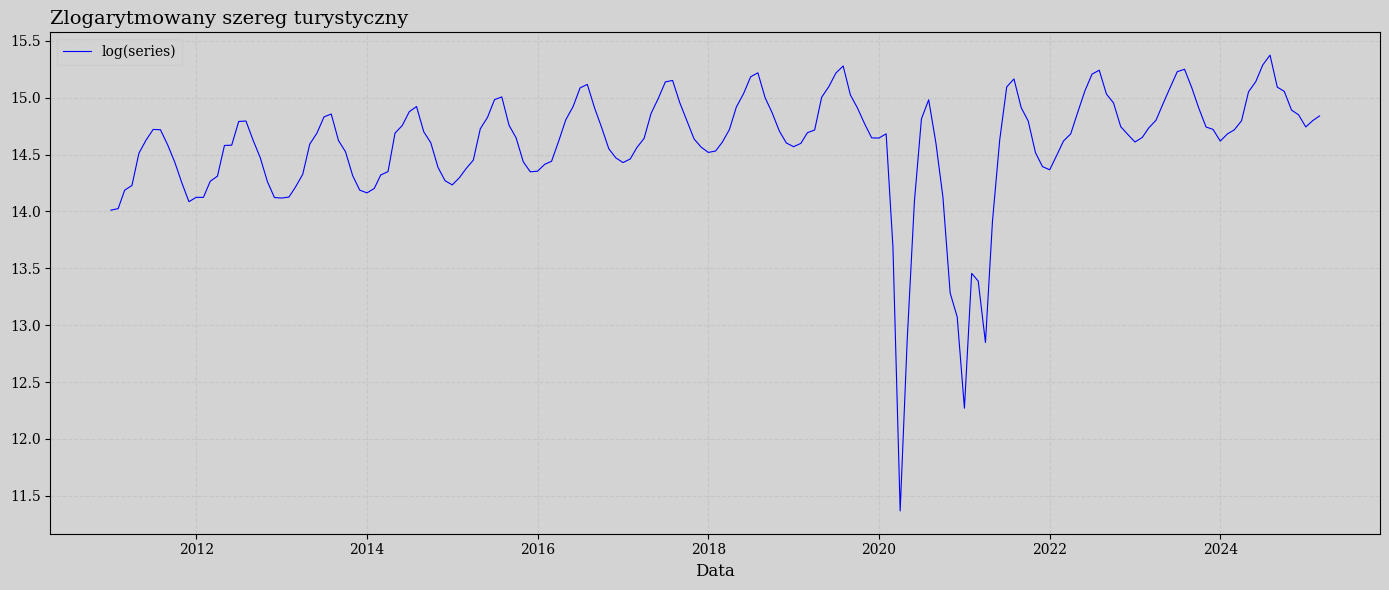

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ── Wczytanie szeregu ──────────────────────────────────────────────────────
file_path = "turystyka_czasowe_2.xlsx"
df = pd.read_excel(file_path)

if "Data" in df.columns:                          # kolumna z datą
    df["Data"] = pd.to_datetime(df["Data"])
    y = df.set_index("Data")["Wartosc"].dropna()
    y = y.asfreq("MS")                            # miesięczna częstotliwość
else:                                             # brak kolumny „Data”
    y = df["Wartosc"].dropna()

# ── Logarytmowanie (w razie potrzeby przesuwamy serię, by była > 0) ────────
if (y <= 0).any():
    shift = abs(y.min()) + 1                      # przesunięcie, aby min > 0
    y_log = np.log(y + shift)
else:
    y_log = np.log(y)

# ── Wykres zlogarytmowanego szeregu ────────────────────────────────────────
plt.figure(figsize=(14, 6))
plt.plot(y_log.index, y_log, color="blue", label="log(series)")
plt.title("Zlogarytmowany szereg turystyczny", fontsize=14, loc="left")
plt.xlabel("Data")
plt.grid(True, which="major", linewidth=0.8)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()


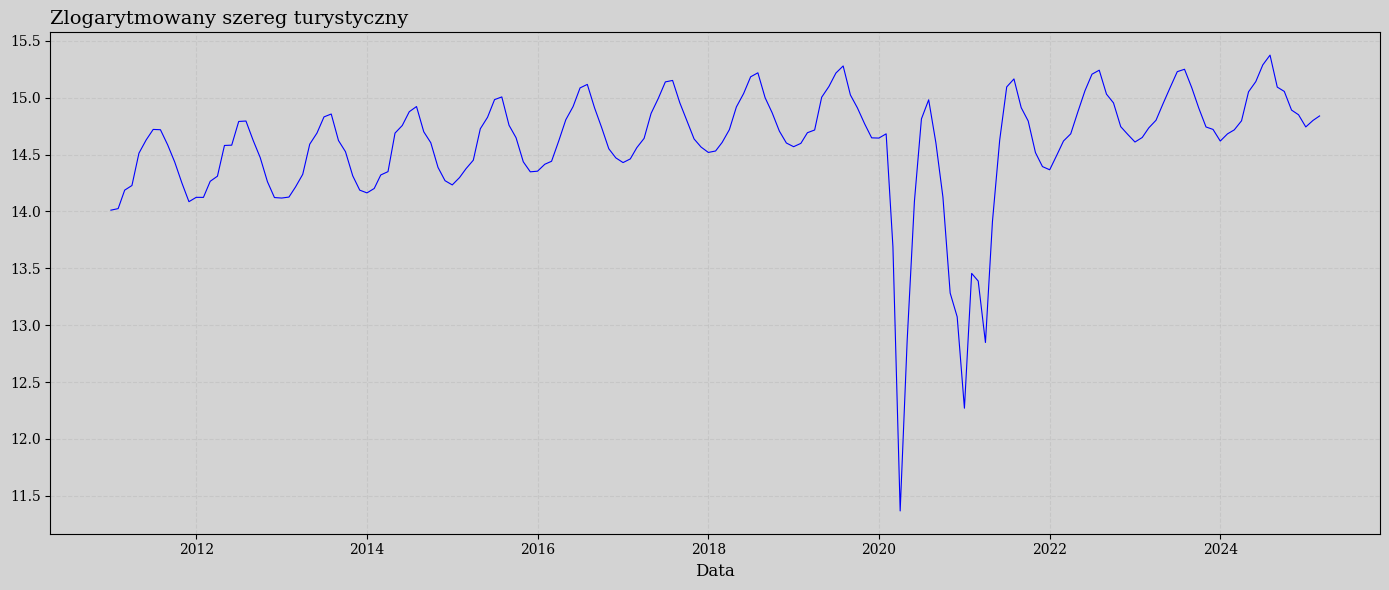


--- Dickey–Fuller ze stałą ---
                            OLS Regression Results                            
Dep. Variable:                Wartosc   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     19.46
Date:                Thu, 05 Jun 2025   Prob (F-statistic):           1.83e-05
Time:                        21:54:47   Log-Likelihood:                -45.417
No. Observations:                 170   AIC:                             94.83
Df Residuals:                     168   BIC:                             101.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.991

In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# ───────────────────────── 1. Wczytaj i zlogarytmuj serię ──────────────────
file_path = "turystyka_czasowe_2.xlsx"
df = pd.read_excel(file_path)

if "Data" in df.columns:
    df["Data"] = pd.to_datetime(df["Data"])
    y = df.set_index("Data")["Wartosc"].dropna().asfreq("MS")
else:
    y = df["Wartosc"].dropna()

# log(x) wymaga dodatnich wartości; w razie potrzeby przesuwamy serię
shift = 0
if (y <= 0).any():
    shift = abs(y.min()) + 1
y_log = np.log(y + shift)

# ───────────────────────── 2. Wykres log-serii ─────────────────────────────
plt.figure(figsize=(14, 6))
plt.plot(y_log, color="blue")
plt.title("Zlogarytmowany szereg turystyczny", loc="left")
plt.xlabel("Data")
plt.grid(True)
plt.tight_layout()
plt.show()

# ───────────────────────── 3. Testy stacjonarności ─────────────────────────
# --- ręczny Dickey–Fuller --------------------------------------------------
yt   = y_log[1:].reset_index(drop=True)
yt_1 = y_log.shift(1)[1:].reset_index(drop=True)
delta = yt - yt_1                       # Δy_t

print("\n--- Dickey–Fuller ze stałą ---")
X_const = sm.add_constant(yt_1)
print(sm.OLS(delta, X_const).fit().summary())

print("\n--- Dickey–Fuller bez stałej ---")
print(sm.OLS(delta, yt_1).fit().summary())

# --- Breusch–Godfrey (autokorelacja reszt) ---------------------------------
print("\n--- Breusch–Godfrey (lag 1–10) dla modelu bez stałej ---")
bg_base = sm.OLS(delta, yt_1).fit()
for lag in range(1, 11):
    bg_stat, p_val = acorr_breusch_godfrey(bg_base, nlags=lag)[:2]
    print(f"lag={lag:2d} | χ²={bg_stat:7.3f} | p={p_val:6.4f}")

# --- Rozszerzony ADF: wszystkie lags 0–20 ----------------------------------
print("\n--- Rozszerzony test ADF (log-seria, lags 0–20, stała) ---")
adf_results = []
for lag in range(0, 21):
    adf_stat, p_val, _, _, _ = adfuller(
        y_log,
        maxlag=lag,
        regression="c",   # z stałą
        autolag=None      # wyłącz automatyczny dobór
    )
    adf_results.append((lag, adf_stat, p_val))
    star = "*" if p_val < 0.05 else ""
    print(f"lag={lag:2d} | stat={adf_stat:8.4f} | p={p_val:6.4f} {star}")

best = min(adf_results, key=lambda x: x[2])
print(f"\nNajmniejsza p-value: lag={best[0]} (p={best[2]:.4f})")
print("⇒", "Odrzucamy H₀ o jednostkowym korzeniu." if best[2] < 0.05
      else "Brak podstaw do odrzucenia H₀ – log-seria prawdopodobnie niestacjonarna.")


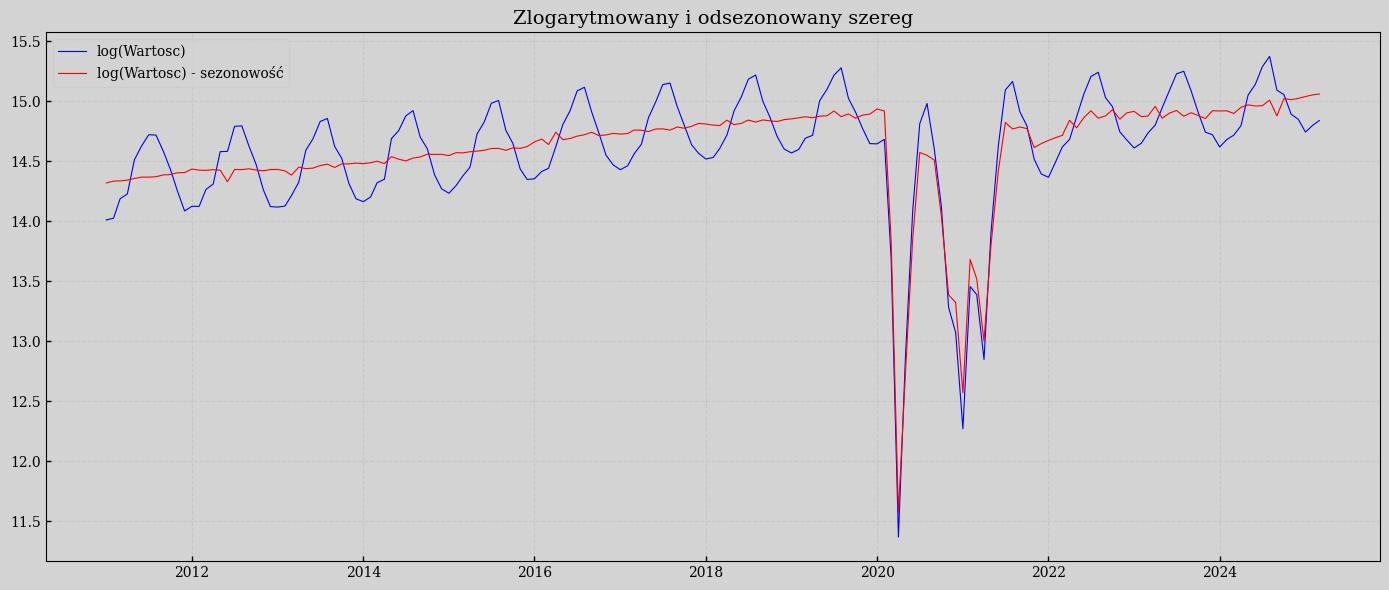


--- Test Dickeya–Haszy–Fullera (ADF) ---
Statystyka ADF       : -2.5880
Wartość p            : 0.0955
Wybrany lag (AIC)    : 12
Wartości krytyczne  :
  1%%: -3.4724
  5%%: -2.8800
  10%%: -2.5766
⇒ Brak podstaw do odrzucenia H₀ – szereg może być niestacjonarny.

--- Test Breuscha–Godfreya dla modelu DF bez stałej ---
lag= 1 | χ²= 10.325 | p=0.0013
lag= 2 | χ²= 13.474 | p=0.0012
lag= 3 | χ²= 13.552 | p=0.0036
lag= 4 | χ²= 18.391 | p=0.0010
lag= 5 | χ²= 21.279 | p=0.0007
lag= 6 | χ²= 27.628 | p=0.0001
lag= 7 | χ²= 27.737 | p=0.0002
lag= 8 | χ²= 30.452 | p=0.0002
lag= 9 | χ²= 32.590 | p=0.0002
lag=10 | χ²= 40.796 | p=0.0000


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

# --- Wczytanie danych ---------------------------------------------------
file_path = "turystyka_czasowe_2.xlsx"
df = pd.read_excel(file_path)

if "Data" in df.columns:
    df["Data"] = pd.to_datetime(df["Data"])
    y = df.set_index("Data")["Wartosc"].dropna()
    y = y.asfreq("MS")
else:
    y = df["Wartosc"].dropna()

# --- Logarytmowanie i odsezonowanie -------------------------------------
y_log = np.log(y)
stl = STL(y_log, period=12, robust=True).fit()
y_sa = y_log - stl.seasonal  # odsezonowany log-szereg

# --- Wykres -------------------------------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(y_log, label="log(Wartosc)", color="blue")
plt.plot(y_sa, label="log(Wartosc) - sezonowość", color="red")
plt.title("Zlogarytmowany i odsezonowany szereg")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Test Dickeya–Haszy–Fullera (ADF) ------------------------------------
print("\n--- Test Dickeya–Haszy–Fullera (ADF) ---")
adf_stat, p_val, used_lag, nobs, crit_vals, _ = adfuller(y_sa, regression="c", autolag="AIC")

print(f"Statystyka ADF       : {adf_stat:.4f}")
print(f"Wartość p            : {p_val:.4f}")
print(f"Wybrany lag (AIC)    : {used_lag}")
print("Wartości krytyczne  :")
for level, value in crit_vals.items():
    print(f"  {level}%: {value:.4f}")
if p_val < 0.05:
    print("⇒ Odrzucamy H₀ – szereg odsezonowany jest stacjonarny.")
else:
    print("⇒ Brak podstaw do odrzucenia H₀ – szereg może być niestacjonarny.")

# --- Ręczna regresja DF do testu BG --------------------------------------
y_diff = y_sa.diff().dropna()
yt = y_diff[1:].reset_index(drop=True)
yt_1 = y_diff.shift(1)[1:].reset_index(drop=True)
delta_y = yt - yt_1

print("\n--- Test Breuscha–Godfreya dla modelu DF bez stałej ---")
model_noconst = sm.OLS(delta_y, yt_1).fit()
for lag in range(1, 11):
    bg_stat, p_val = acorr_breusch_godfrey(model_noconst, nlags=lag)[:2]
    print(f"lag={lag:2d} | χ²={bg_stat:7.3f} | p={p_val:.4f}")


In [26]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

# --- Wczytywanie danych --------------------------------------------------
file_path = "turystyka_czasowe_2.xlsx"
df = pd.read_excel(file_path)

# Przygotowanie szeregu
if 'Data' in df.columns:
    df['Data'] = pd.to_datetime(df['Data'])
    y = df.set_index('Data')["Wartosc"].dropna()
else:
    y = df["Wartosc"].dropna().reset_index(drop=True)

# --- Logarytmowanie szeregu ----------------------------------------------
y_log = np.log(y)

# --- Test Dickeya–Haszy–Fullera (ADF) z autolag ------------------------------------
print("\n--- Test Dickeya–Haszy–Fullera (ADF) ---")
adf_result = adfuller(y_log, regression='c', autolag='AIC')
adf_stat, p_val, used_lag, nobs, crit_vals = adf_result[:5]

print(f"Statystyka testowa ADF : {adf_stat:.4f}")
print(f"Wartość p              : {p_val:.4f}")
print(f"Wybrany lag (AIC)      : {used_lag}")
print("Wartości krytyczne    :")
for level, val in crit_vals.items():
    print(f"  {level}%: {val:.4f}")

if p_val < 0.05:
    print("⇒ Odrzucamy H₀ – szereg jest stacjonarny.")
else:
    print("⇒ Brak podstaw do odrzucenia H₀ – szereg może być niestacjonarny.")

# --- Ręczna ekstrakcja lagowanych Δy dla inspekcji ---------------------------
print("\n--- Pierwsze 5 obserwacji lagowanych różnic (Δy) ---")
delta_y = y_log.diff().dropna().reset_index(drop=True)

# Utwórz DataFrame z kolejnymi lagami (od 1 do wybranego)
lags_df = pd.concat([delta_y.shift(i) for i in range(1, used_lag + 1)], axis=1)
lags_df.columns = [f"Δy(t-{i})" for i in range(1, used_lag + 1)]

print(lags_df.head(5))



--- Test Dickeya–Haszy–Fullera (ADF) ---
Statystyka testowa ADF : -2.2326
Wartość p              : 0.1946
Wybrany lag (AIC)      : 12
Wartości krytyczne    :
  1%%: -3.4724
  5%%: -2.8800
  10%%: -2.5766
⇒ Brak podstaw do odrzucenia H₀ – szereg może być niestacjonarny.

--- Pierwsze 5 obserwacji lagowanych różnic (Δy) ---
    Δy(t-1)   Δy(t-2)   Δy(t-3)   Δy(t-4)  Δy(t-5)  Δy(t-6)  Δy(t-7)  Δy(t-8)  \
0       NaN       NaN       NaN       NaN      NaN      NaN      NaN      NaN   
1  0.013651       NaN       NaN       NaN      NaN      NaN      NaN      NaN   
2  0.162506  0.013651       NaN       NaN      NaN      NaN      NaN      NaN   
3  0.040584  0.162506  0.013651       NaN      NaN      NaN      NaN      NaN   
4  0.284353  0.040584  0.162506  0.013651      NaN      NaN      NaN      NaN   

   Δy(t-9)  Δy(t-10)  Δy(t-11)  Δy(t-12)  
0      NaN       NaN       NaN       NaN  
1      NaN       NaN       NaN       NaN  
2      NaN       NaN       NaN       NaN  
3      NaN      

Dane wczytane pomyślnie.


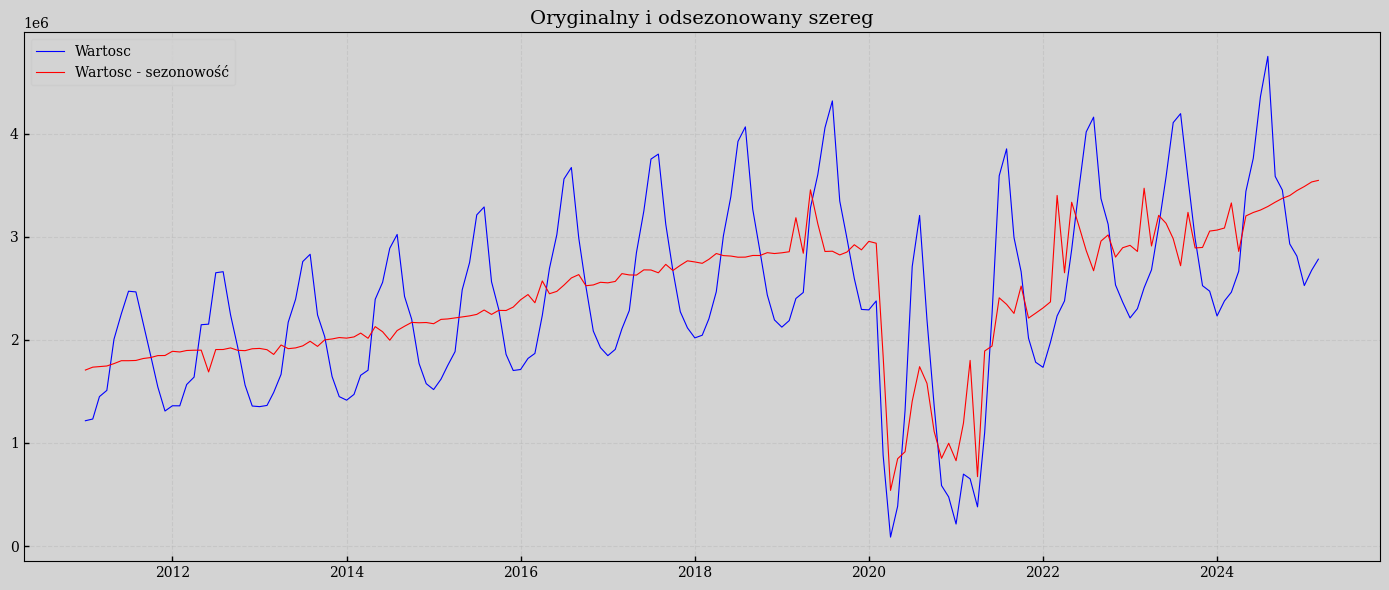


--- Test Dickeya–Haszy–Fullera (ADF) ---
Statystyka ADF       : -2.9838
Wartość p            : 0.0364
Wybrany lag (AIC)    : 12
Wartości krytyczne  :
  1%%: -3.4724
  5%%: -2.8800
  10%%: -2.5766
⇒ Odrzucamy H₀ – szereg odsezonowany jest stacjonarny.

--- Test Breuscha–Godfreya dla reszt z prostego modelu AR(1) na odsezonowanym szeregu ---
lag= 1 | χ²= 10.963 | p=0.0009
lag= 2 | χ²= 11.369 | p=0.0034
lag= 3 | χ²= 11.369 | p=0.0099
lag= 4 | χ²= 16.737 | p=0.0022
lag= 5 | χ²= 18.154 | p=0.0028
lag= 6 | χ²= 18.630 | p=0.0048
lag= 7 | χ²= 21.364 | p=0.0033
lag= 8 | χ²= 22.108 | p=0.0047
lag= 9 | χ²= 22.317 | p=0.0079
lag=10 | χ²= 31.422 | p=0.0005


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
import statsmodels.api as sm
import numpy as np
import matplotlib.dates as mdates

# --- Styl wykresów ---
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman', 'DejaVu Serif', 'Arial'],
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'lines.linewidth': 0.8,
    'lines.markersize': 6,
    'scatter.edgecolors': 'black',
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
    'grid.linestyle': '--',
    'grid.color': '#aaaaaa',
    'grid.alpha': 0.3,
    'figure.figsize': (14, 7),
    'figure.facecolor': 'lightgrey',
    'axes.facecolor': 'lightgrey'
})

# --- Wczytanie danych ---------------------------------------------------
file_path = "turystyka_czasowe_2.xlsx"
try:
    df = pd.read_excel(file_path)

    if "Data" in df.columns:
        df["Data"] = pd.to_datetime(df["Data"])
        y = df.set_index("Data")["Wartosc"].dropna()
        y = y.asfreq("MS") # Upewnij się, że indeks jest równoodległy miesięcznie
    else:
        y = df["Wartosc"].dropna()
        print("Brak kolumny 'Data'. Szereg czasowy nie ma indeksu daty. Upewnij się, że dane są uporządkowane czasowo.")
        # Jeśli nie ma kolumny 'Data', STL może mieć problem z 'period'.
        # W tym przypadku period=12 zakłada dane miesięczne.

    print("Dane wczytane pomyślnie.")

except FileNotFoundError:
    print(f"Błąd: Plik '{file_path}' nie został znaleziony. Upewnij się, że plik jest w katalogu lub podaj pełną ścieżkę.")
    exit()
except KeyError:
    print("Błąd: Kolumna 'Wartosc' nie została znaleziona w pliku.")
    exit()

# --- Odsezonowanie (bez logarytmowania) -------------------------------------
# STL na oryginalnym szeregu (bez logarytmowania)
stl = STL(y, period=12, robust=True).fit()
y_sa = y - stl.seasonal  # odsezonowany szereg

# --- Wykres -------------------------------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(y, label="Wartosc", color="blue")
plt.plot(y_sa, label="Wartosc - sezonowość", color="red")
plt.title("Oryginalny i odsezonowany szereg")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Test Dickeya–Fullera (ADF) ------------------------------------------
print("\n--- Test Dickeya–Haszy–Fullera (ADF) ---")
# Test ADF dla odsezonowanego szeregu (już bez logarytmowania)
adf_stat, p_val, used_lag, nobs, crit_vals, _ = adfuller(y_sa, regression="c", autolag="AIC")

print(f"Statystyka ADF       : {adf_stat:.4f}")
print(f"Wartość p            : {p_val:.4f}")
print(f"Wybrany lag (AIC)    : {used_lag}")
print("Wartości krytyczne  :")
for level, value in crit_vals.items():
    print(f"  {level}%: {value:.4f}")
if p_val < 0.05:
    print("⇒ Odrzucamy H₀ – szereg odsezonowany jest stacjonarny.")
else:
    print("⇒ Brak podstaw do odrzucenia H₀ – szereg może być niestacjonarny.")

# --- Ręczna regresja DF do testu BG --------------------------------------
# Test BG dla odsezonowanego szeregu (już bez logarytmowania)
y_diff = y_sa.diff().dropna()
# Jeśli y_diff jest zbyt krótkie (np. po jednym różnicowaniu), poniższe linie mogą się nie powieść.
# Sprawdź, czy y_diff ma wystarczającą długość dla tych operacji
if len(y_diff) > 1:
    # W teście Breuscha-Godfreya często testuje się reszty z regresji pomocniczej.
    # Tutaj symulujemy krok z testu Dickeya-Fullera dla potrzeb demonstracji testu BG.
    # Tworzymy zmienne dla regresji pomocniczej, która jest podstawą dla testu BG.
    # Zgodnie z formatem testu DF/ADF, dla testu BG na resztach z modelu DF,
    # należy przeprowadzić regresję reszt na opóźnionych resztach i oryginalnych opóźnionych wartościach.
    # W tym przypadku, upraszczamy, używając pierwszej różnicy i jej opóźnienia.

    # Tworzymy opóźnioną zmienną dla regresji.
    # Na potrzeby testu BG, potrzebujemy dopasować model regresji do y_sa.
    # Najczęściej test BG jest stosowany do reszt z głównego modelu (np. z ARIMA).
    # Tutaj, na potrzeby kontynuacji, dopasujemy prosty model AR(1) do y_sa.
    # Jeśli chcesz testować BG na resztach z modelu DF/ADF, to ten fragment wymagałby bardziej zaawansowanej konstrukcji,
    # która symulowałaby dokładnie model regresji z testu DF/ADF, a następnie brała jego reszty.
    # Używamy prostego podejścia do demonstracji działania BG.

    # Regresja pomocnicza na potrzeby testu BG
    # Model: y_sa_t = const + beta * y_sa_{t-1} + error_t
    y_sa_shifted = y_sa.shift(1).dropna()
    y_sa_trimmed = y_sa[y_sa_shifted.index] # Dopasuj indeksy
    
    # Dodaj stałą do regresorów
    X_bg = sm.add_constant(y_sa_shifted)

    print("\n--- Test Breuscha–Godfreya dla reszt z prostego modelu AR(1) na odsezonowanym szeregu ---")
    try:
        model_for_bg = sm.OLS(y_sa_trimmed, X_bg).fit()
        # Test Breuscha-Godfreya na resztach z tego modelu
        for lag in range(1, 11): # Testowanie do 10 opóźnień
            bg_stat, p_val, _, _ = acorr_breusch_godfrey(model_for_bg, nlags=lag)
            print(f"lag={lag:2d} | χ²={bg_stat:7.3f} | p={p_val:.4f}")
    except ValueError as e:
        print(f"Błąd podczas dopasowywania modelu OLS lub testu BG: {e}")
        print("Upewnij się, że szereg ma wystarczającą zmienność i długość.")
else:
    print("Błąd: Szereg odsezonowany jest zbyt krótki, aby przeprowadzić testy BG.")


Dane wczytane pomyślnie.


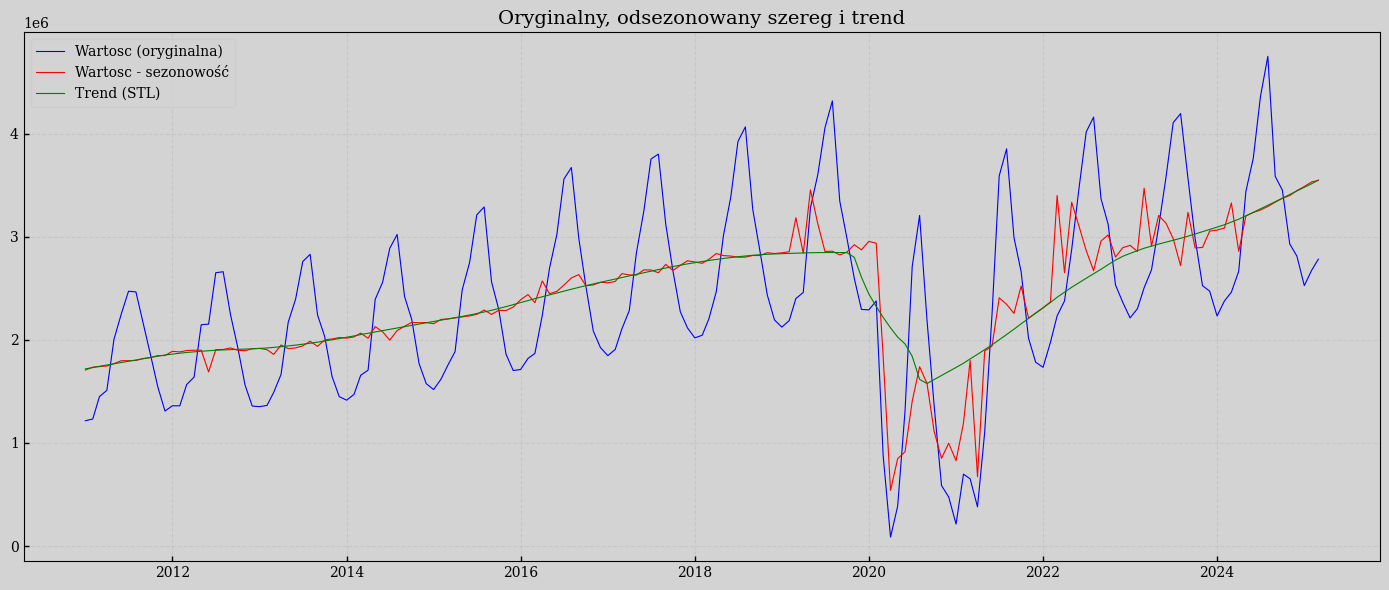


--- Test Dickeya–Haszy–Fullera (ADF) ---
Statystyka ADF       : -2.9838
Wartość p            : 0.0364
Wybrany lag (AIC)    : 12
Wartości krytyczne  :
  1%%: -3.4724
  5%%: -2.8800
  10%%: -2.5766
⇒ Odrzucamy H₀ – szereg odsezonowany jest stacjonarny.

--- Test Breuscha–Godfreya dla reszt z prostego modelu AR(1) na odsezonowanym szeregu ---
lag= 1 | χ²= 10.963 | p=0.0009
lag= 2 | χ²= 11.369 | p=0.0034
lag= 3 | χ²= 11.369 | p=0.0099
lag= 4 | χ²= 16.737 | p=0.0022
lag= 5 | χ²= 18.154 | p=0.0028
lag= 6 | χ²= 18.630 | p=0.0048
lag= 7 | χ²= 21.364 | p=0.0033
lag= 8 | χ²= 22.108 | p=0.0047
lag= 9 | χ²= 22.317 | p=0.0079
lag=10 | χ²= 31.422 | p=0.0005


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
import statsmodels.api as sm
import numpy as np
import matplotlib.dates as mdates

# --- Styl wykresów ---
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman', 'DejaVu Serif', 'Arial'],
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'lines.linewidth': 0.8,
    'lines.markersize': 6,
    'scatter.edgecolors': 'black',
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
    'grid.linestyle': '--',
    'grid.color': '#aaaaaa',
    'grid.alpha': 0.3,
    'figure.figsize': (14, 7),
    'figure.facecolor': 'lightgrey',
    'axes.facecolor': 'lightgrey'
})

# --- Wczytanie danych ---------------------------------------------------
file_path = "turystyka_czasowe_2.xlsx"
try:
    df = pd.read_excel(file_path)

    if "Data" in df.columns:
        df["Data"] = pd.to_datetime(df["Data"])
        y = df.set_index("Data")["Wartosc"].dropna()
        y = y.asfreq("MS") # Upewnij się, że indeks jest równoodległy miesięcznie
    else:
        y = df["Wartosc"].dropna()
        print("Brak kolumny 'Data'. Szereg czasowy nie ma indeksu daty. Upewnij się, że dane są uporządkowane czasowo.")
        # Jeśli nie ma kolumny 'Data', STL może mieć problem z 'period'.
        # W tym przypadku period=12 zakłada dane miesięczne.

    print("Dane wczytane pomyślnie.")

except FileNotFoundError:
    print(f"Błąd: Plik '{file_path}' nie został znaleziony. Upewnij się, że plik jest w katalogu lub podaj pełną ścieżkę.")
    exit()
except KeyError:
    print("Błąd: Kolumna 'Wartosc' nie została znaleziona w pliku.")
    exit()

# --- Odsezonowanie (bez logarytmowania) -------------------------------------
# STL na oryginalnym szeregu (bez logarytmowania)
stl = STL(y, period=12, robust=True).fit()
y_sa = y - stl.seasonal  # odsezonowany szereg
y_trend = stl.trend # Pobranie komponentu trendu

# --- Wykres -------------------------------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(y, label="Wartosc (oryginalna)", color="blue")
plt.plot(y_sa, label="Wartosc - sezonowość", color="red")
plt.plot(y_trend, label="Trend (STL)", color="green", linestyle='-') # Dodana zielona linia trendu
plt.title("Oryginalny, odsezonowany szereg i trend")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Test Dickeya–Fullera (ADF) ------------------------------------------
print("\n--- Test Dickeya–Haszy–Fullera (ADF) ---")
# Test ADF dla odsezonowanego szeregu (już bez logarytmowania)
adf_stat, p_val, used_lag, nobs, crit_vals, _ = adfuller(y_sa, regression="c", autolag="AIC")

print(f"Statystyka ADF       : {adf_stat:.4f}")
print(f"Wartość p            : {p_val:.4f}")
print(f"Wybrany lag (AIC)    : {used_lag}")
print("Wartości krytyczne  :")
for level, value in crit_vals.items():
    print(f"  {level}%: {value:.4f}")
if p_val < 0.05:
    print("⇒ Odrzucamy H₀ – szereg odsezonowany jest stacjonarny.")
else:
    print("⇒ Brak podstaw do odrzucenia H₀ – szereg może być niestacjonarny.")

# --- Ręczna regresja DF do testu BG --------------------------------------
# Test BG dla odsezonowanego szeregu (już bez logarytmowania)
y_diff = y_sa.diff().dropna()
# Jeśli y_diff jest zbyt krótkie (np. po jednym różnicowaniu), poniższe linie mogą się nie powieść.
# Sprawdź, czy y_diff ma wystarczającą długość dla tych operacji
if len(y_diff) > 1:
    # W teście Breuscha-Godfreya często testuje się reszty z regresji pomocniczej.
    # Tutaj symulujemy krok z testu Dickeya-Fullera dla potrzeb demonstracji testu BG.
    # Tworzymy zmienne dla regresji pomocniczej, która jest podstawą dla testu BG.
    # Zgodnie z formatem testu DF/ADF, dla testu BG na resztach z modelu DF,
    # należy przeprowadzić regresję reszt na opóźnionych resztach i oryginalnych opóźnionych wartościach.
    # W tym przypadku, upraszczamy, używając pierwszej różnicy i jej opóźnienia.

    # Tworzymy opóźnioną zmienną dla regresji.
    # Na potrzeby testu BG, potrzebujemy dopasować model regresji do y_sa.
    # Najczęściej test BG jest stosowany do reszt z głównego modelu (np. z ARIMA).
    # Tutaj, na potrzeby kontynuacji, dopasujemy prosty model AR(1) do y_sa.
    # Jeśli chcesz testować BG na resztach z modelu DF/ADF, to ten fragment wymagałby bardziej zaawansowanej konstrukcji,
    # która symulowałaby dokładnie model regresji z testu DF/ADF, a następnie brała jego reszty.
    # Używamy prostego podejścia do demonstracji działania BG.

    # Regresja pomocnicza na potrzeby testu BG
    # Model: y_sa_t = const + beta * y_sa_{t-1} + error_t
    y_sa_shifted = y_sa.shift(1).dropna()
    y_sa_trimmed = y_sa[y_sa_shifted.index] # Dopasuj indeksy
    
    # Dodaj stałą do regresorów
    X_bg = sm.add_constant(y_sa_shifted)

    print("\n--- Test Breuscha–Godfreya dla reszt z prostego modelu AR(1) na odsezonowanym szeregu ---")
    try:
        model_for_bg = sm.OLS(y_sa_trimmed, X_bg).fit()
        # Test Breuscha-Godfreya na resztach z tego modelu
        for lag in range(1, 11): # Testowanie do 10 opóźnień
            bg_stat, p_val, _, _ = acorr_breusch_godfrey(model_for_bg, nlags=lag)
            print(f"lag={lag:2d} | χ²={bg_stat:7.3f} | p={p_val:.4f}")
    except ValueError as e:
        print(f"Błąd podczas dopasowywania modelu OLS lub testu BG: {e}")
        print("Upewnij się, że szereg ma wystarczającą zmienność i długość.")
else:
    print("Błąd: Szereg odsezonowany jest zbyt krótki, aby przeprowadzić testy BG.")

Dane wczytane pomyślnie.


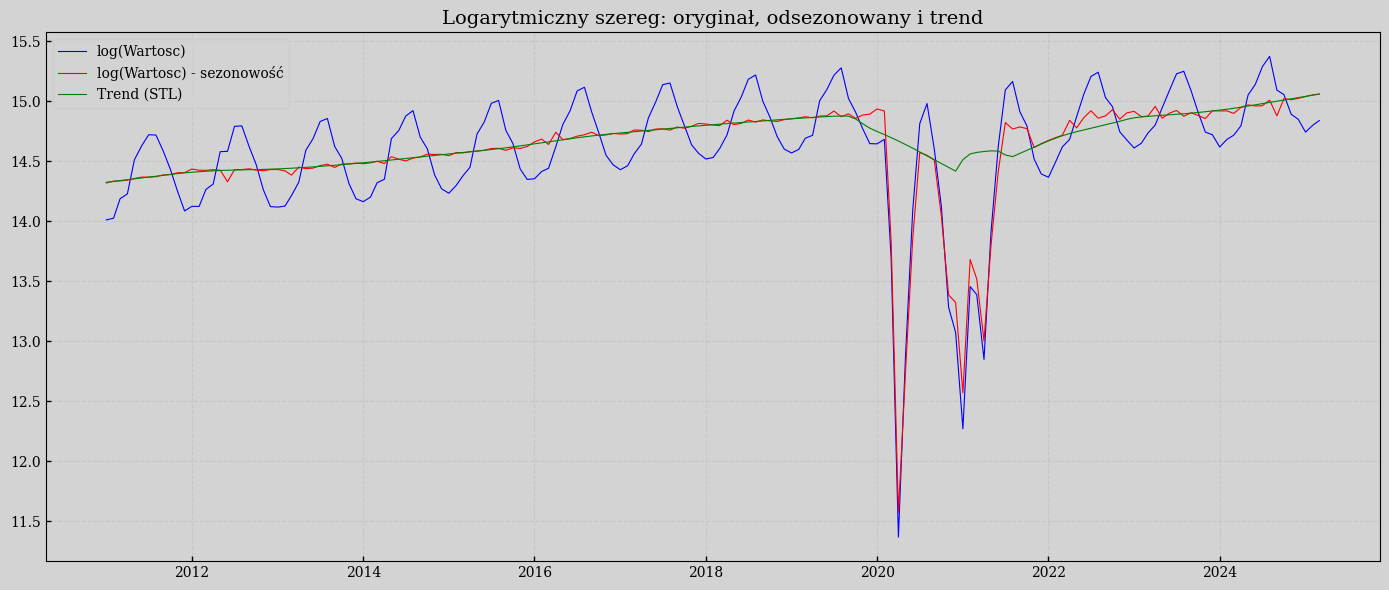


--- Test Dickeya–Fullera (ADF) na logarytmowanym, odsezonowanym szeregu (dla lagów 1–20) ---
lag= 1 | ADF= -5.1654 | p=0.0000 | ⇒ STACJONARNY
lag= 2 | ADF= -4.1911 | p=0.0007 | ⇒ STACJONARNY
lag= 3 | ADF= -4.1911 | p=0.0007 | ⇒ STACJONARNY
lag= 4 | ADF= -4.1911 | p=0.0007 | ⇒ STACJONARNY
lag= 5 | ADF= -4.1911 | p=0.0007 | ⇒ STACJONARNY
lag= 6 | ADF= -4.1911 | p=0.0007 | ⇒ STACJONARNY
lag= 7 | ADF= -4.1911 | p=0.0007 | ⇒ STACJONARNY
lag= 8 | ADF= -4.1911 | p=0.0007 | ⇒ STACJONARNY
lag= 9 | ADF= -4.1911 | p=0.0007 | ⇒ STACJONARNY
lag=10 | ADF= -1.7368 | p=0.4123 | ⇒ NIESTACJONARNY
lag=11 | ADF= -1.9853 | p=0.2931 | ⇒ NIESTACJONARNY
lag=12 | ADF= -2.5880 | p=0.0955 | ⇒ NIESTACJONARNY
lag=13 | ADF= -2.5880 | p=0.0955 | ⇒ NIESTACJONARNY
lag=14 | ADF= -2.5880 | p=0.0955 | ⇒ NIESTACJONARNY
lag=15 | ADF= -2.5880 | p=0.0955 | ⇒ NIESTACJONARNY
lag=16 | ADF= -2.5880 | p=0.0955 | ⇒ NIESTACJONARNY
lag=17 | ADF= -2.5880 | p=0.0955 | ⇒ NIESTACJONARNY
lag=18 | ADF= -2.5880 | p=0.0955 | ⇒ NIESTACJONAR

/var/folders/fq/y2pp37qx2bx57fqz9jt54cgc0000gn/T/ipykernel_70698/750305080.py:85: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_val_kpss, _, _ = kpss(y_log_sa, regression='c', nlags=lag)
/var/folders/fq/y2pp37qx2bx57fqz9jt54cgc0000gn/T/ipykernel_70698/750305080.py:85: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_val_kpss, _, _ = kpss(y_log_sa, regression='c', nlags=lag)
/var/folders/fq/y2pp37qx2bx57fqz9jt54cgc0000gn/T/ipykernel_70698/750305080.py:85: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_val_kpss, _, _ = kpss(y_log_sa, regression='c', nlags=lag)
/var/folders/fq/y2pp37qx2bx57fq

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
import statsmodels.api as sm
import numpy as np

# --- Styl wykresów ---
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman', 'DejaVu Serif', 'Arial'],
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'lines.linewidth': 0.8,
    'lines.markersize': 6,
    'scatter.edgecolors': 'black',
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
    'grid.linestyle': '--',
    'grid.color': '#aaaaaa',
    'grid.alpha': 0.3,
    'figure.figsize': (14, 7),
    'figure.facecolor': 'lightgrey',
    'axes.facecolor': 'lightgrey'
})

# --- Wczytanie danych ---
file_path = "turystyka_czasowe_2.xlsx"
try:
    df = pd.read_excel(file_path)

    if "Data" in df.columns:
        df["Data"] = pd.to_datetime(df["Data"])
        y = df.set_index("Data")["Wartosc"].dropna()
        y = y.asfreq("MS")
    else:
        y = df["Wartosc"].dropna()
        print("Brak kolumny 'Data'. Szereg nie ma indeksu daty.")

    print("Dane wczytane pomyślnie.")
except Exception as e:
    print(f"Błąd podczas wczytywania: {e}")
    exit()

# --- Logarytmowanie szeregu ---
y_log = np.log(y)
y_log = y_log.replace([np.inf, -np.inf], np.nan).dropna()

# --- Odsezonowanie (STL) ---
stl_log = STL(y_log, period=12, robust=True).fit()
y_log_sa = y_log - stl_log.seasonal
y_log_trend = stl_log.trend

# --- Wykres logarytmowanego szeregu ---
plt.figure(figsize=(14, 6))
plt.plot(y_log, label="log(Wartosc)", color="blue")
plt.plot(y_log_sa, label="log(Wartosc) - sezonowość", color="red")
plt.plot(y_log_trend, label="Trend (STL)", color="green", linestyle='-')
plt.title("Logarytmiczny szereg: oryginał, odsezonowany i trend")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Test Dickeya-Fullera (ADF) ---
print("\n--- Test Dickeya–Fullera (ADF) na logarytmowanym, odsezonowanym szeregu (dla lagów 1–20) ---")
for lag in range(1, 21):
    try:
        adf_stat, p_val, _, _, _, _ = adfuller(y_log_sa, maxlag=lag, regression="c")
        interpretacja = "STACJONARNY" if p_val < 0.05 else "NIESTACJONARNY"
        print(f"lag={lag:2d} | ADF={adf_stat:8.4f} | p={p_val:.4f} | ⇒ {interpretacja}")
    except Exception as e:
        print(f"lag={lag:2d} | Błąd: {e}")

# --- Test KPSS ---
print("\n--- Test KPSS na logarytmowanym, odsezonowanym szeregu (dla lagów 1–20) ---")
for lag in range(1, 21):
    try:
        kpss_stat, p_val_kpss, _, _ = kpss(y_log_sa, regression='c', nlags=lag)
        interpretacja = "STACJONARNY" if p_val_kpss > 0.05 else "NIESTACJONARNY"
        print(f"lag={lag:2d} | KPSS={kpss_stat:8.4f} | p={p_val_kpss:.4f} | ⇒ {interpretacja}")
    except Exception as e:
        print(f"lag={lag:2d} | Błąd: {e}")

# --- Test Breuscha–Godfreya (BG) ---
y_log_diff = y_log_sa.diff().dropna()
if len(y_log_diff) > 1:
    y_shifted = y_log_sa.shift(1).dropna()
    y_trimmed = y_log_sa[y_shifted.index]
    X_bg = sm.add_constant(y_shifted)

    print("\n--- Test Breuscha–Godfreya (BG) dla modelu AR(1) na logarytmowanym, odsezonowanym szeregu ---")
    try:
        model_for_bg = sm.OLS(y_trimmed, X_bg).fit()
        for lag in range(1, 11):
            bg_stat, p_val, _, _ = acorr_breusch_godfrey(model_for_bg, nlags=lag)
            print(f"lag={lag:2d} | χ²={bg_stat:7.3f} | p={p_val:.4f}")
    except ValueError as e:
        print(f"Błąd modelu lub testu BG: {e}")
else:
    print("Szereg zbyt krótki do testu BG.")


In [55]:
from pmdarima import auto_arima

model = auto_arima(y_log_sa, start_p=1, start_q=1,
                   max_p=5, max_q=5,
                   d=0,           # bo stacjonarny
                   seasonal=False,
                   stepwise=True, trace=True,
                   suppress_warnings=True, error_action='ignore')

print(model.summary())


ModuleNotFoundError: No module named 'pmdarima'

Dane wczytane pomyślnie.


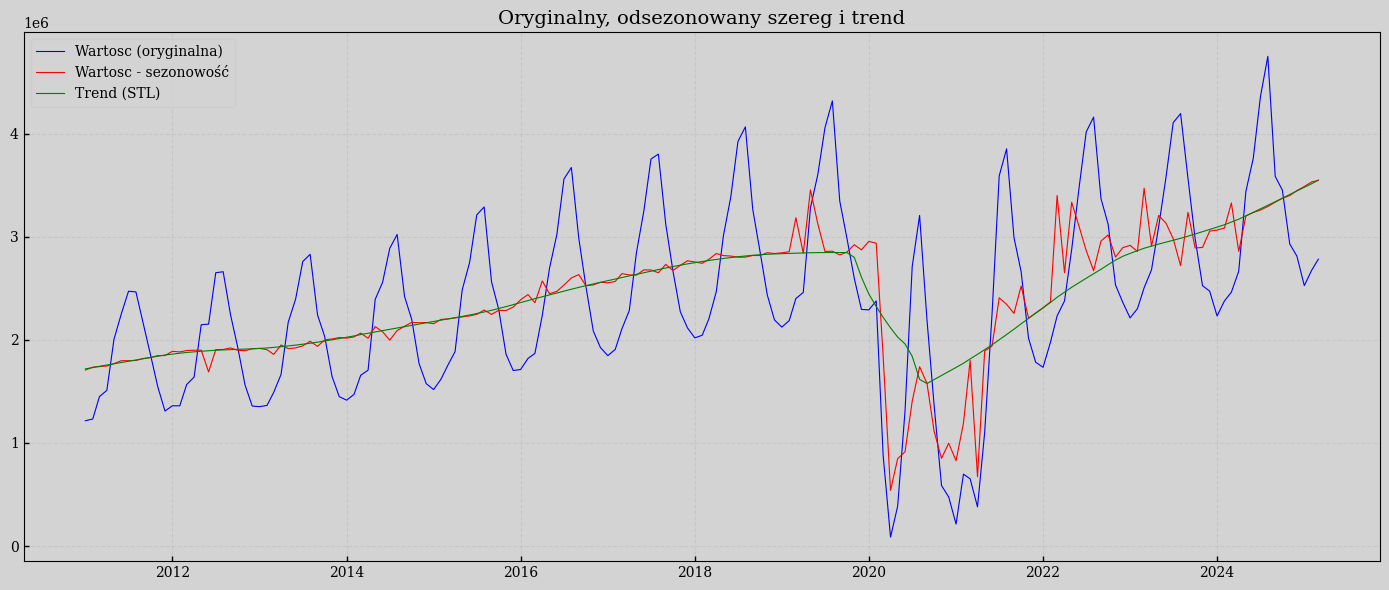


--- Test Dickeya–Haszy–Fullera (ADF) na oryginalnym szeregu ---
Statystyka ADF       : -2.1185
Wartość p            : 0.2371
Wybrany lag (AIC)    : 13
Wartości krytyczne  :
  1%%: -3.4727
  5%%: -2.8801
  10%%: -2.5767
⇒ Szereg **może być niestacjonarny** (brak podstaw do odrzucenia H₀).

--- Test KPSS na oryginalnym szeregu ---
Statystyka KPSS      : 1.2355
Wartość p            : 0.0100
Wybrany lag          : 1
Wartości krytyczne  :
  10%%: 0.3470
  5%%: 0.4630
  2.5%%: 0.5740
  1%%: 0.7390
⇒ Szereg **jest niestacjonarny** (odrzucamy H₀ o stacjonarności – obecność pierwiastka jednostkowego).

--- Test Breuscha–Godfreya dla reszt z prostego modelu AR(1) na oryginalnym szeregu ---
lag= 1 | χ²= 62.137 | p=0.0000
lag= 2 | χ²= 62.524 | p=0.0000
lag= 3 | χ²= 64.445 | p=0.0000
lag= 4 | χ²= 66.365 | p=0.0000
lag= 5 | χ²= 68.140 | p=0.0000
lag= 6 | χ²= 70.184 | p=0.0000
lag= 7 | χ²= 77.739 | p=0.0000
lag= 8 | χ²= 92.134 | p=0.0000
lag= 9 | χ²= 92.242 | p=0.0000
lag=10 | χ²= 92.741 | p=0.0000


/var/folders/fq/y2pp37qx2bx57fqz9jt54cgc0000gn/T/ipykernel_70698/3507649280.py:94: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, p_val_kpss, lags_kpss, crit_vals_kpss = kpss(y, regression='c', nlags=1)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss # Dodano kpss
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
import statsmodels.api as sm
import numpy as np
import matplotlib.dates as mdates

# --- Styl wykresów ---
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman', 'DejaVu Serif', 'Arial'],
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'lines.linewidth': 0.8,
    'lines.markersize': 6,
    'scatter.edgecolors': 'black',
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
    'grid.linestyle': '--',
    'grid.color': '#aaaaaa',
    'grid.alpha': 0.3,
    'figure.figsize': (14, 7),
    'figure.facecolor': 'lightgrey',
    'axes.facecolor': 'lightgrey'
})

# --- Wczytanie danych ---------------------------------------------------
file_path = "turystyka_czasowe_2.xlsx"
try:
    df = pd.read_excel(file_path)

    if "Data" in df.columns:
        df["Data"] = pd.to_datetime(df["Data"])
        y = df.set_index("Data")["Wartosc"].dropna()
        y = y.asfreq("MS") # Upewnij się, że indeks jest równoodległy miesięcznie
    else:
        y = df["Wartosc"].dropna()
        print("Brak kolumny 'Data'. Szereg czasowy nie ma indeksu daty. Upewnij się, że dane są uporządkowane czasowo.")
        # Jeśli nie ma kolumny 'Data', STL może mieć problem z 'period'.
        # W tym przypadku period=12 zakłada dane miesięczne.

    print("Dane wczytane pomyślnie.")

except FileNotFoundError:
    print(f"Błąd: Plik '{file_path}' nie został znaleziony. Upewnij się, że plik jest w katalogu lub podaj pełną ścieżkę.")
    exit()
except KeyError:
    print("Błąd: Kolumna 'Wartosc' nie została znaleziona w pliku.")
    exit()

# --- Odsezonowanie (bez logarytmowania) -------------------------------------
# STL na oryginalnym szeregu (bez logarytmowania)
stl = STL(y, period=12, robust=True).fit()
y_sa = y - stl.seasonal  # odsezonowany szereg
y_trend = stl.trend # Pobranie komponentu trendu

# --- Wykres -------------------------------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(y, label="Wartosc (oryginalna)", color="blue")
plt.plot(y_sa, label="Wartosc - sezonowość", color="red")
plt.plot(y_trend, label="Trend (STL)", color="green", linestyle='-') # Dodana zielona linia trendu
plt.title("Oryginalny, odsezonowany szereg i trend")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n--- Test Dickeya–Haszy–Fullera (ADF) na oryginalnym szeregu ---")
adf_stat, p_val, used_lag, nobs, crit_vals, _ = adfuller(y, regression="c", autolag="AIC")

print(f"Statystyka ADF       : {adf_stat:.4f}")
print(f"Wartość p            : {p_val:.4f}")
print(f"Wybrany lag (AIC)    : {used_lag}")
print("Wartości krytyczne  :")
for level, value in crit_vals.items():
    print(f"  {level}%: {value:.4f}")

interpretacja_adf = (
    "⇒ Szereg **jest stacjonarny** (odrzucamy hipotezę H₀ o niestacjonarności)."
    if p_val < 0.05
    else "⇒ Szereg **może być niestacjonarny** (brak podstaw do odrzucenia H₀)."
)
print(interpretacja_adf)


print("\n--- Test KPSS na oryginalnym szeregu ---")
kpss_stat, p_val_kpss, lags_kpss, crit_vals_kpss = kpss(y, regression='c', nlags=12)

print(f"Statystyka KPSS      : {kpss_stat:.4f}")
print(f"Wartość p            : {p_val_kpss:.4f}")
print(f"Wybrany lag          : {lags_kpss}")
print("Wartości krytyczne  :")
for level, value in crit_vals_kpss.items():
    print(f"  {level}%: {value:.4f}")

interpretacja_kpss = (
    "⇒ Szereg **jest stacjonarny** (brak podstaw do odrzucenia H₀ o stacjonarności)."
    if p_val_kpss > 0.05
    else "⇒ Szereg **jest niestacjonarny** (odrzucamy H₀ o stacjonarności – obecność pierwiastka jednostkowego)."
)
print(interpretacja_kpss)


# --- Test BG dla oryginalnego szeregu (nieodsezonowanego) ---
y_diff = y.diff().dropna()
if len(y_diff) > 1:
    y_shifted = y.shift(1).dropna()
    y_trimmed = y[y_shifted.index]

    X_bg = sm.add_constant(y_shifted)

    print("\n--- Test Breuscha–Godfreya dla reszt z prostego modelu AR(1) na oryginalnym szeregu ---")
    try:
        model_for_bg = sm.OLS(y_trimmed, X_bg).fit()
        for lag in range(1, 11):
            bg_stat, p_val, _, _ = acorr_breusch_godfrey(model_for_bg, nlags=lag)
            print(f"lag={lag:2d} | χ²={bg_stat:7.3f} | p={p_val:.4f}")
    except ValueError as e:
        print(f"Błąd podczas dopasowywania modelu OLS lub testu BG: {e}")
        print("Upewnij się, że szereg ma wystarczającą zmienność i długość.")
else:
    print("Błąd: Szereg jest zbyt krótki, aby przeprowadzić testy BG.")


Dane wczytane pomyślnie.


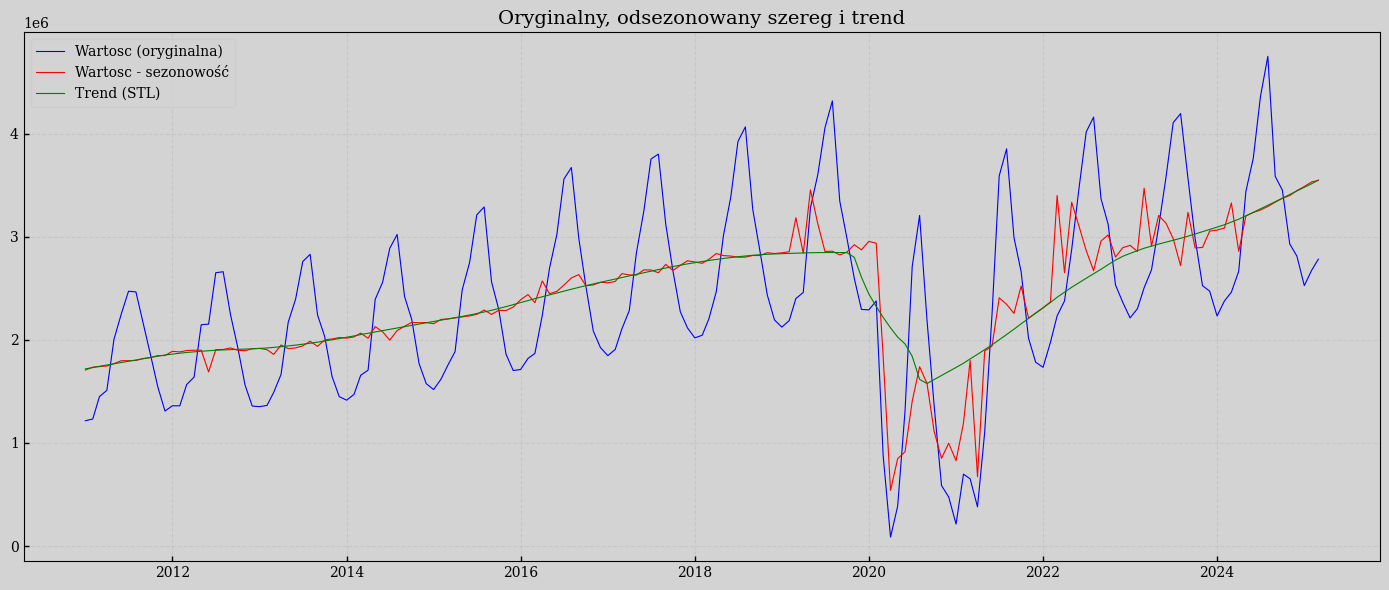


--- Test Dickeya–Fullera (ADF) na odsezonowanym szeregu (dla lagów 1–20) ---
lag= 1 | ADF= -2.5355 | p=0.3104 | ⇒ NIESTACJONARNY
lag= 2 | ADF= -2.5355 | p=0.3104 | ⇒ NIESTACJONARNY
lag= 3 | ADF= -2.5355 | p=0.3104 | ⇒ NIESTACJONARNY
lag= 4 | ADF= -2.5355 | p=0.3104 | ⇒ NIESTACJONARNY
lag= 5 | ADF= -2.5355 | p=0.3104 | ⇒ NIESTACJONARNY
lag= 6 | ADF= -2.5355 | p=0.3104 | ⇒ NIESTACJONARNY
lag= 7 | ADF= -2.5355 | p=0.3104 | ⇒ NIESTACJONARNY
lag= 8 | ADF= -2.5355 | p=0.3104 | ⇒ NIESTACJONARNY
lag= 9 | ADF= -2.5355 | p=0.3104 | ⇒ NIESTACJONARNY
lag=10 | ADF= -3.3385 | p=0.0602 | ⇒ NIESTACJONARNY
lag=11 | ADF= -2.4583 | p=0.3491 | ⇒ NIESTACJONARNY
lag=12 | ADF= -3.8905 | p=0.0125 | ⇒ STACJONARNY
lag=13 | ADF= -3.8905 | p=0.0125 | ⇒ STACJONARNY
lag=14 | ADF= -3.8905 | p=0.0125 | ⇒ STACJONARNY
lag=15 | ADF= -3.8905 | p=0.0125 | ⇒ STACJONARNY
lag=16 | ADF= -3.8905 | p=0.0125 | ⇒ STACJONARNY
lag=17 | ADF= -3.8905 | p=0.0125 | ⇒ STACJONARNY
lag=18 | ADF= -1.7677 | p=0.7201 | ⇒ NIESTACJONARNY
lag=

/var/folders/fq/y2pp37qx2bx57fqz9jt54cgc0000gn/T/ipykernel_70698/98600657.py:88: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, p_val_kpss, _, crit_vals_kpss = kpss(y_sa, regression='ct', nlags=lag)
/var/folders/fq/y2pp37qx2bx57fqz9jt54cgc0000gn/T/ipykernel_70698/98600657.py:88: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, p_val_kpss, _, crit_vals_kpss = kpss(y_sa, regression='ct', nlags=lag)
/var/folders/fq/y2pp37qx2bx57fqz9jt54cgc0000gn/T/ipykernel_70698/98600657.py:88: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, p_val_kpss, _, crit_vals_kpss = kpss(y_sa, regression='ct', nlags=lag)
/var

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
import statsmodels.api as sm
import numpy as np
import matplotlib.dates as mdates

# --- Styl wykresów ---
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman', 'DejaVu Serif', 'Arial'],
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'lines.linewidth': 0.8,
    'lines.markersize': 6,
    'scatter.edgecolors': 'black',
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
    'grid.linestyle': '--',
    'grid.color': '#aaaaaa',
    'grid.alpha': 0.3,
    'figure.figsize': (14, 7),
    'figure.facecolor': 'lightgrey',
    'axes.facecolor': 'lightgrey'
})

# --- Wczytanie danych ---
file_path = "turystyka_czasowe_2.xlsx"
try:
    df = pd.read_excel(file_path)

    if "Data" in df.columns:
        df["Data"] = pd.to_datetime(df["Data"])
        y = df.set_index("Data")["Wartosc"].dropna()
        y = y.asfreq("MS")  # miesięczna częstotliwość
    else:
        y = df["Wartosc"].dropna()
        print("Brak kolumny 'Data'. Szereg czasowy nie ma indeksu daty.")

    print("Dane wczytane pomyślnie.")

except FileNotFoundError:
    print(f"Błąd: Plik '{file_path}' nie został znaleziony.")
    exit()
except KeyError:
    print("Błąd: Kolumna 'Wartosc' nie została znaleziona.")
    exit()

# --- Dekompozycja STL ---
stl = STL(y, period=12, robust=True).fit()
y_sa = y - stl.seasonal  # odsezonowany
y_trend = stl.trend      # trend

# --- Wykres ---
plt.figure(figsize=(14, 6))
plt.plot(y, label="Wartosc (oryginalna)", color="blue")
plt.plot(y_sa, label="Wartosc - sezonowość", color="red")
plt.plot(y_trend, label="Trend (STL)", color="green", linestyle='-')
plt.title("Oryginalny, odsezonowany szereg i trend")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Test ADF dla lagów 1–20 ---
print("\n--- Test Dickeya–Fullera (ADF) na odsezonowanym szeregu (dla lagów 1–20) ---")
for lag in range(1, 21):
    try:
        adf_stat, p_val, _, _, crit_vals, _ = adfuller(y_sa, maxlag=lag, regression="ct")
        interpretacja = (
            "STACJONARNY" if p_val < 0.05 else "NIESTACJONARNY"
        )
        print(f"lag={lag:2d} | ADF={adf_stat:8.4f} | p={p_val:.4f} | ⇒ {interpretacja}")
    except Exception as e:
        print(f"lag={lag:2d} | Błąd: {e}")

# --- Test KPSS dla lagów 1–20 ---
print("\n--- Test KPSS na odsezonowanym szeregu (dla lagów 1–20) ---")
for lag in range(1, 21):
    try:
        kpss_stat, p_val_kpss, _, crit_vals_kpss = kpss(y_sa, regression='ct', nlags=lag)
        interpretacja = (
            "STACJONARNY" if p_val_kpss > 0.05 else "NIESTACJONARNY"
        )
        print(f"lag={lag:2d} | KPSS={kpss_stat:8.4f} | p={p_val_kpss:.4f} | ⇒ {interpretacja}")
    except Exception as e:
        print(f"lag={lag:2d} | Błąd: {e}")

# --- Test Breuscha–Godfreya (BG) dla odsezonowanego szeregu ---
y_diff = y_sa.diff().dropna()
if len(y_diff) > 1:
    y_shifted = y_sa.shift(1).dropna()
    y_trimmed = y_sa[y_shifted.index]
    X_bg = sm.add_constant(y_shifted)

    print("\n--- Test Breuscha–Godfreya dla reszt z modelu AR(1) na odsezonowanym szeregu ---")
    try:
        model_for_bg = sm.OLS(y_trimmed, X_bg).fit()
        for lag in range(1, 11):
            bg_stat, p_val, _, _ = acorr_breusch_godfrey(model_for_bg, nlags=lag)
            print(f"lag={lag:2d} | χ²={bg_stat:7.3f} | p={p_val:.4f}")
    except ValueError as e:
        print(f"Błąd modelu lub testu BG: {e}")
else:
    print("Szereg zbyt krótki do przeprowadzenia testu BG.")


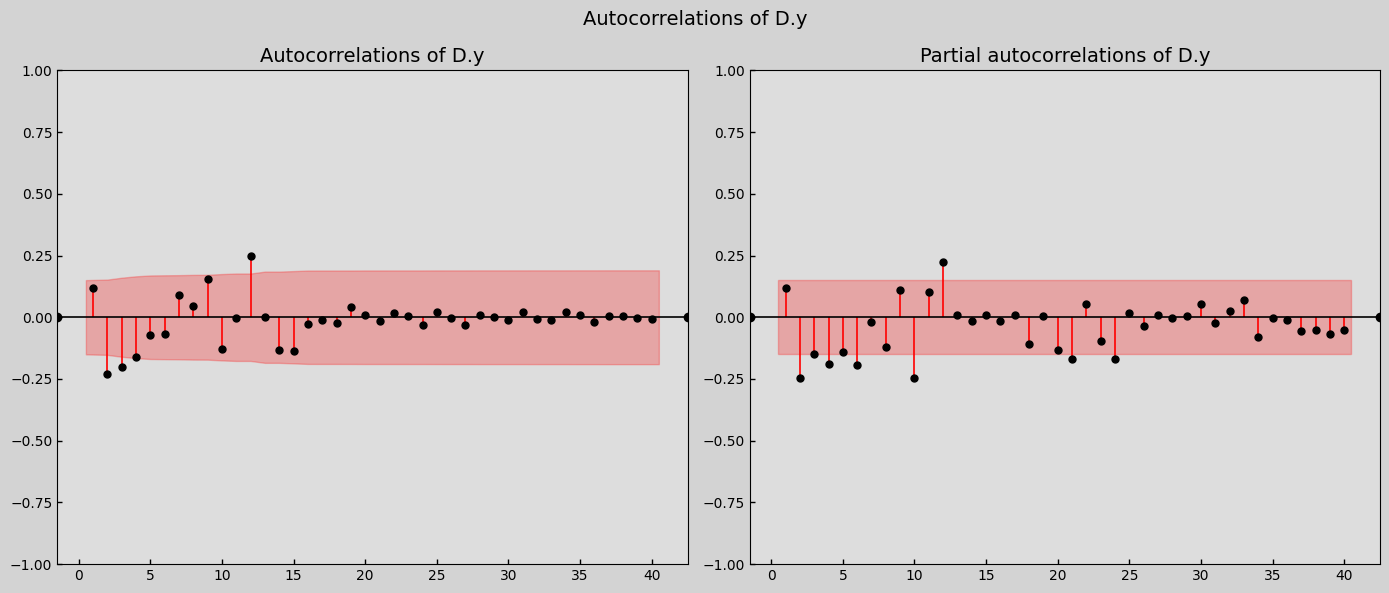

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL


plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans', 'Arial'],
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'lines.linewidth': 1.2,
    'lines.markersize': 6,
    'scatter.edgecolors': 'black',
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
    'grid.linestyle': '',         # brak siatki
    'grid.alpha': 0.0,            # przezroczysta siatka
    'figure.figsize': (14, 6),
    'figure.facecolor': '#dddddd',
    'axes.facecolor': '#dddddd',
    'axes.edgecolor': 'black',
    'savefig.facecolor': '#dddddd',
})


# --- Przygotowanie szeregu ---
# y: Twój oryginalny szereg czasowy z datami
# y_log_sa: logarytmowany, odsezonowany szereg

# Jeśli nie masz y_log_sa:
# y_log = np.log(y).replace([np.inf, -np.inf], np.nan).dropna()
# y_log_sa = y_log - STL(y_log, period=12, robust=True).fit().seasonal

# --- Różnicowanie (opcjonalnie) ---
# Użyj różnicowania, jeśli analizujesz D.y jak na wykresie
D_y = y_log_sa.diff().dropna()

# --- Styl ACF/PACF jak na Twoim zrzucie ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), facecolor='lightgrey')
fig.suptitle("Autocorrelations of D.y", fontsize=14)

# --- ACF ---
plot_acf(D_y, lags=40, ax=axes[0], alpha=0.05, zero=False,
         title="Autocorrelations of D.y", color='red', marker='o')

# --- PACF ---
plot_pacf(D_y, lags=40, ax=axes[1], alpha=0.05, zero=False,
          title="Partial autocorrelations of D.y", color='red', marker='o', method='ywm')

# --- Styl zgodny z Twoim zrzutem ---
for ax in axes:
    ax.set_facecolor("#dddddd")   # szare tło
    for line in ax.lines:
        line.set_color('black')   # czarne słupki
    for dot in ax.collections:
        dot.set_facecolor("red")  # czerwone punkty
        dot.set_edgecolor("red")
    ax.grid(False)

plt.tight_layout()
plt.show()
